# Aligning single-cell resolution breast cancer spatial transcriptomics data to corresponding H&E staining image from Xenium

In this notebook, we take a single cell resolution spatial transcriptomics datasets of a breast cancer section profiled by the Xenium technology and align it to a corresponding H&E staining image of the same tissue section. See the bioRxiv preprint for more details about this data: https://www.biorxiv.org/content/10.1101/2022.10.06.510405v2 

According to the authors, "Due to the non-destructive nature of the Xenium workflow, we were able to perform H&E staining...on the same section post-processing." However, as the H&E staining and imaging was done seprately to the spatial transcriptomics data collection, alignment is still needed to register the H&E staining image with the single cell positions from the spatial transcriptomics data. 

We will use `STalign` to achieve this alignment. We will first load the relevant code libraries.

In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
# OPTION A: import STalign after pip or pipenv install
from STalign import STalign

In [3]:
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 

## import STalign from upper directory
import STalign

To obtain the single cell spatial transcriptomics data, we can download the `Xenium Output Bundle` from the 10X website: https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast Expanding the downloaded `Xenium_FFPE_Human_Breast_Cancer_Rep1_outs.zip`, we will use the single cell positions stored in `cells.csv.gz`. Likewise, we can download the accompanying H&E staining image `Supplemental: Post-Xenium H&E image (TIFF)` as `Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif`. 

To reproduce this tutorial, we have placed these files in a folder called [`xenium_data/`](https://github.com/JEFworks-Lab/STalign/tree/main/docs/xenium_data) with `cells.csv.gz` renamed as `Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz` for organizational purposes. Likewise, to minimize storage, we have resized the high resolution H&E TIF image into a smaller PNG image as `Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.png`

We can read in the H&E staining image using `matplotlib.pyplot` as `plt`. 

In [5]:

# read in data
fname = '/home/u5552013/Datasets/REACTIVAS/Data/Nuclei/1_HE_1007260.csv'
df1 = pd.read_csv(fname)
print(df1.head())

              x            y                  type      prob
0  15441.365621  2556.252481  overall_inflammatory  1.000000
1  15295.593489  2250.416832  overall_inflammatory  1.000000
2  15259.388646  2253.275109  overall_inflammatory  1.000000
3  15199.364827  2336.165145  overall_inflammatory  0.999512
4  15458.515284  2564.827312  overall_inflammatory  0.995117


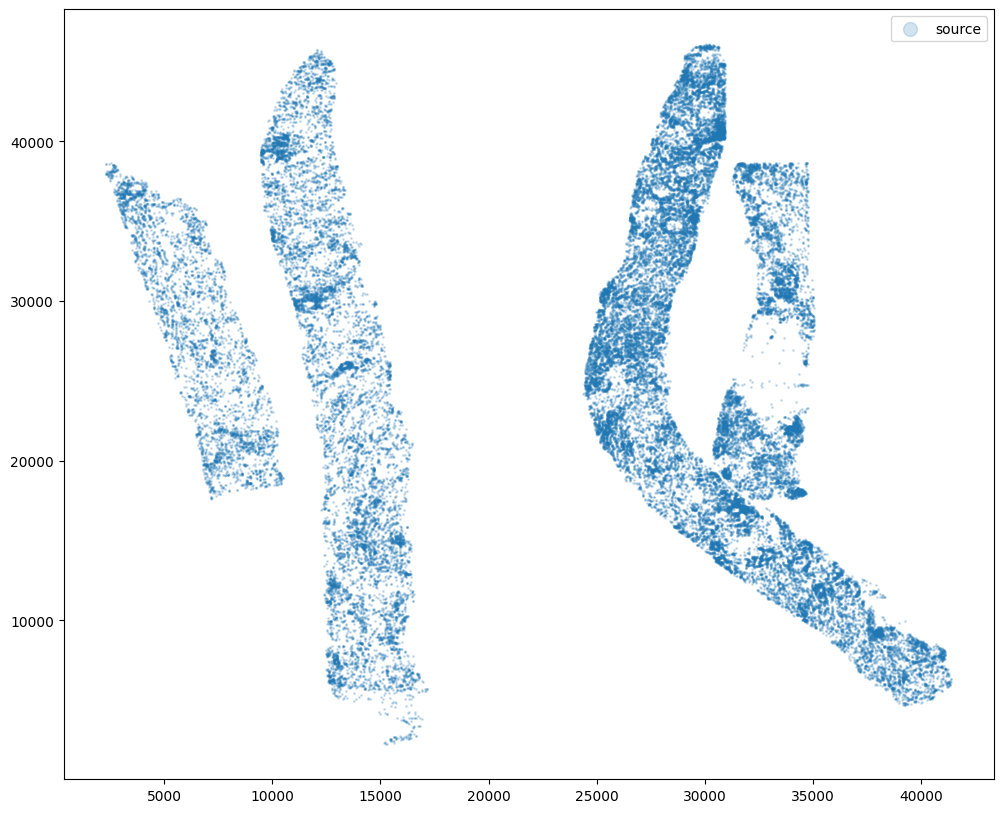

In [6]:
# get cell centroid coordinates
xI = np.array(df1['x'])
yI = np.array(df1['y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source')
ax.legend(markerscale = 10)

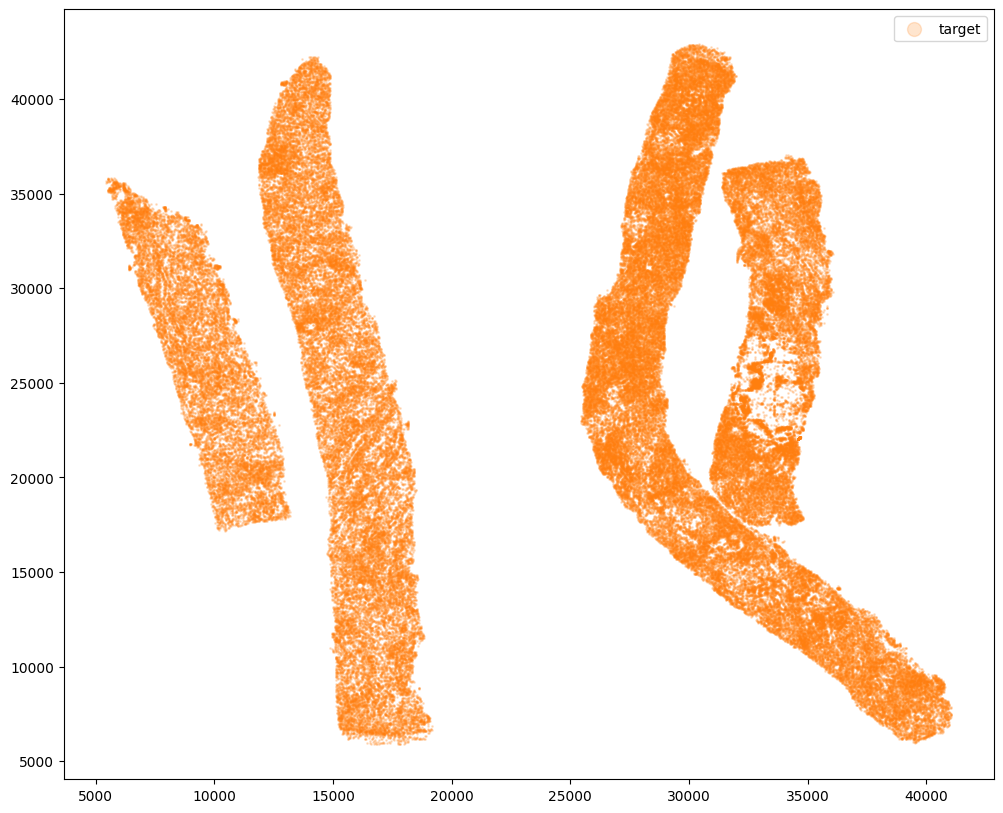

In [7]:
# Single cell data 2
# read in data
fname = '/home/u5552013/Datasets/REACTIVAS/Data/Annotations_mif/csvs/1_ome_nuclei.csv'

df2 = pd.read_csv(fname)

# get cell centroids
xJ = np.array(df2['global_x'])
yJ = np.array(df2['global_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.2,c='#ff7f0e', label='target')
ax.legend(markerscale = 10)

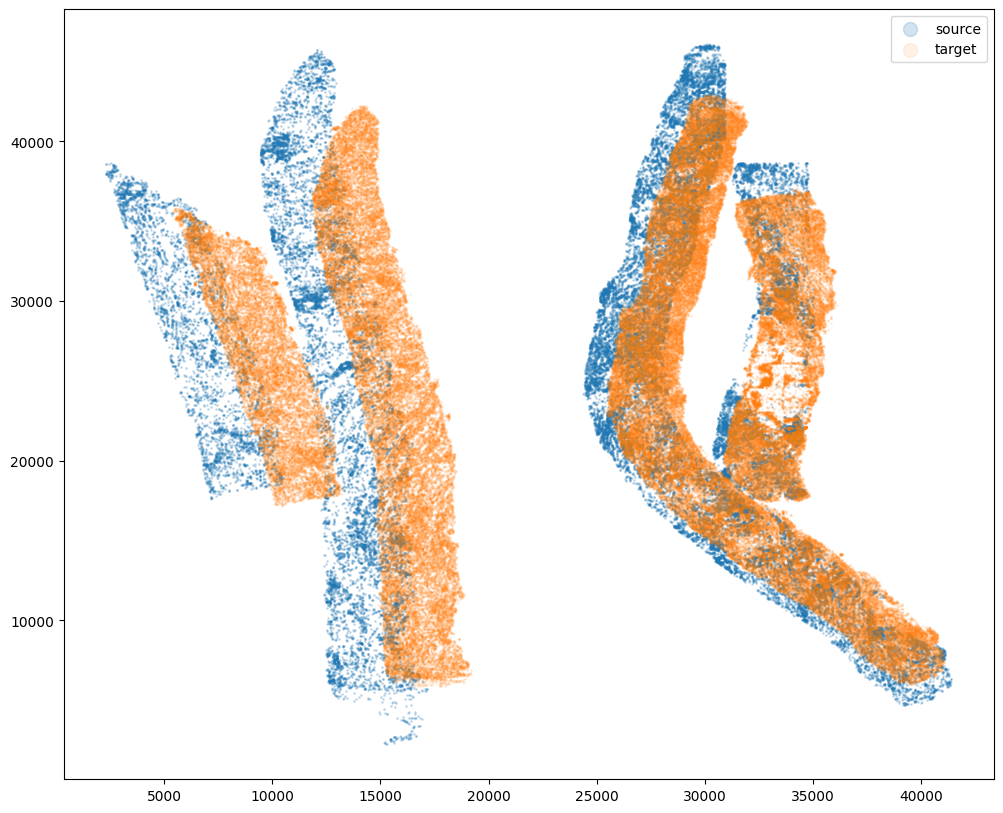

In [8]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label= 'target')
ax.legend(markerscale = 10)

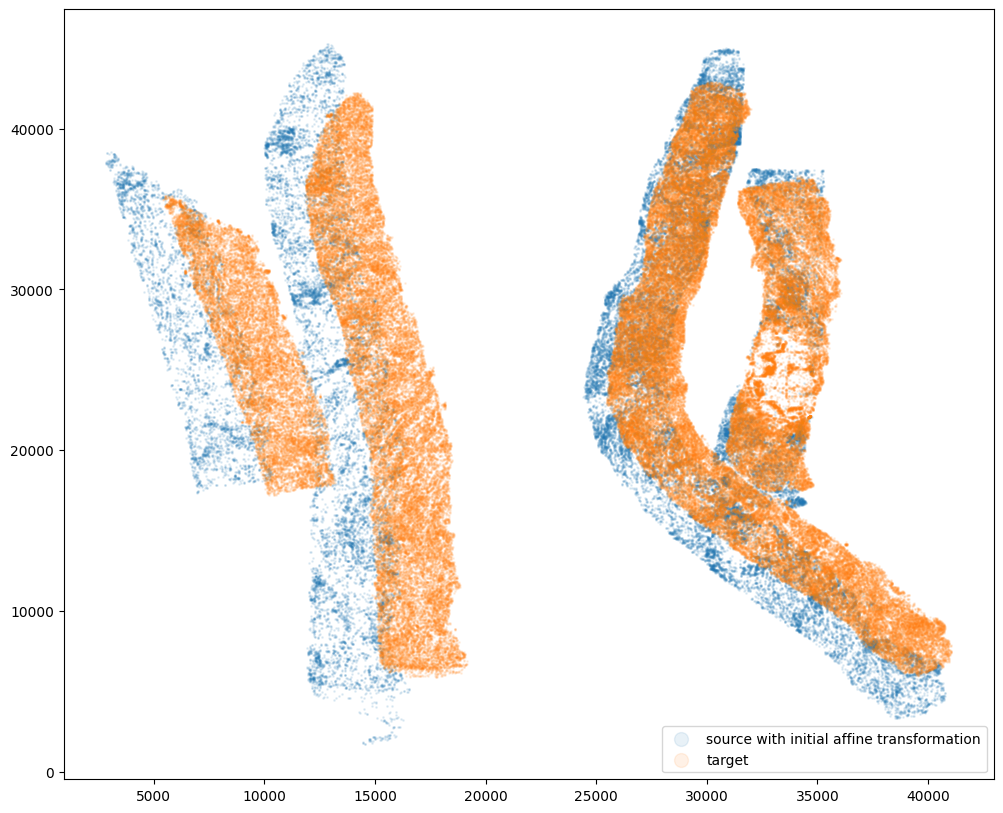

In [10]:
theta_deg = 2
theta0 = (np.pi/180)*-theta_deg

#rotation matrix
#rotates about the origin
L = np.array([[np.cos(theta0),-np.sin(theta0)],
              [np.sin(theta0),np.cos(theta0)]])

source_L = np.matmul(L , np.array([xI, yI]))
xI_L = source_L[0]
yI_L = source_L[1]

#translation matrix
#effectively makes the rotation about the centroid of I (i.e the means of xI and yI])
#and also moves the centroid of I to the centroid of J
T = np.array([ np.mean(xI)- np.cos(theta0)*np.mean(xI) +np.sin(theta0)*np.mean(yI) - (np.mean(xI)-np.mean(xJ)),
              np.mean(yI)- np.sin(theta0)*np.mean(xI) -np.cos(theta0)*np.mean(yI) - (np.mean(yI)-np.mean(yJ))])

xI_L_T = xI_L + T[0]
yI_L_T = yI_L + T[1]


fig,ax = plt.subplots()
ax.scatter(xI_L_T,yI_L_T,s=1,alpha=0.1, label='source with initial affine transformation')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label = 'target')
ax.legend(markerscale = 10)

0 of 58695
10000 of 58695
20000 of 58695
30000 of 58695
40000 of 58695
50000 of 58695
58694 of 58695


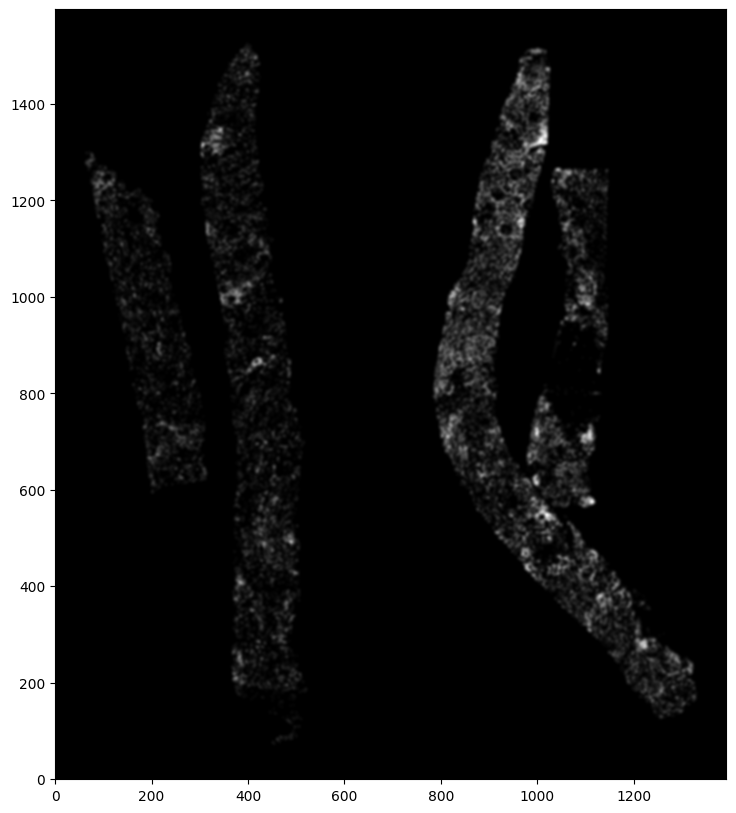

In [15]:
# rasterize at 30um resolution (assuming positions are in um units) and plot 
from STalign.STalign import rasterize

# rasterize at 30um resolution (assuming positions are in um units) and plot      
XI, YI, I, fig = rasterize(xI_L_T, yI_L_T, dx=30, blur=1.5)

# plot
ax = fig.axes[0]
     
# XI,YI,I,fig = STalign.rasterize(xI_L_T,yI_L_T,dx=30,blur=1.5)

# # plot
# ax = fig.axes[0]
ax.invert_yaxis()

0 of 152325
10000 of 152325
20000 of 152325
30000 of 152325
40000 of 152325
50000 of 152325
60000 of 152325
70000 of 152325
80000 of 152325
90000 of 152325
100000 of 152325
110000 of 152325
120000 of 152325
130000 of 152325
140000 of 152325
150000 of 152325
152324 of 152325


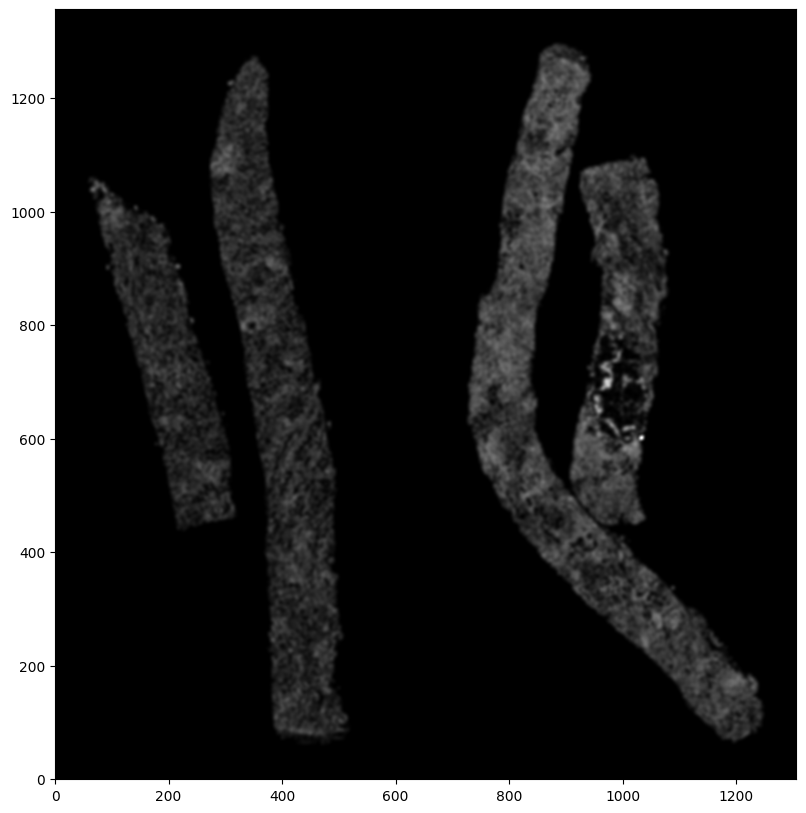

In [16]:
# rasterize and plot
XJ,YJ,J,fig = rasterize(xJ,yJ,dx=30, blur=1.5)
ax = fig.axes[0]
ax.invert_yaxis()

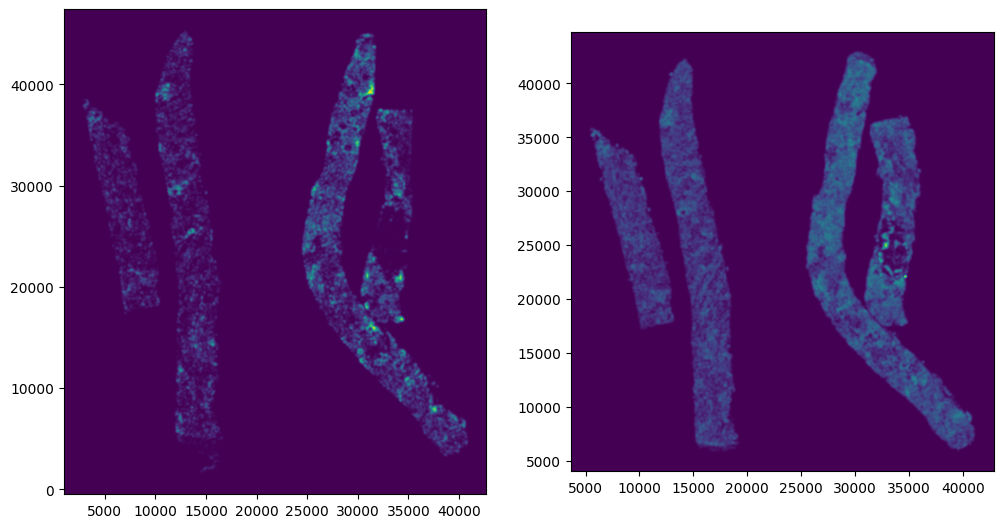

In [19]:
# get extent of images
from STalign.STalign import extent_from_x
extentI = extent_from_x((YI,XI))
extentJ =extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow(I[0], extent=extentI)
ax[1].imshow(J[0], extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

CPU times: user 11min 21s, sys: 12.8 s, total: 11min 34s
Wall time: 1min 14s


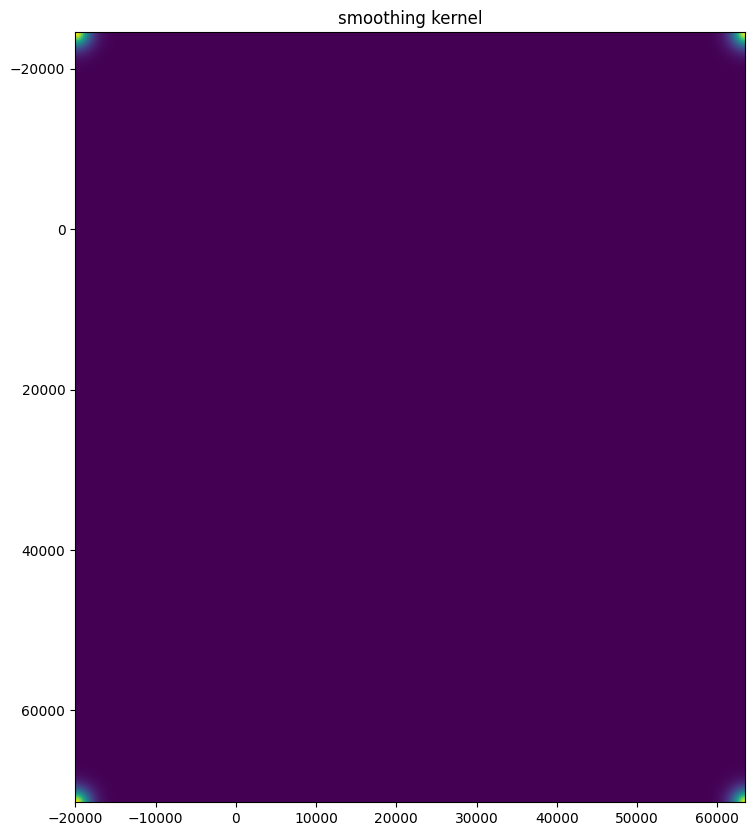

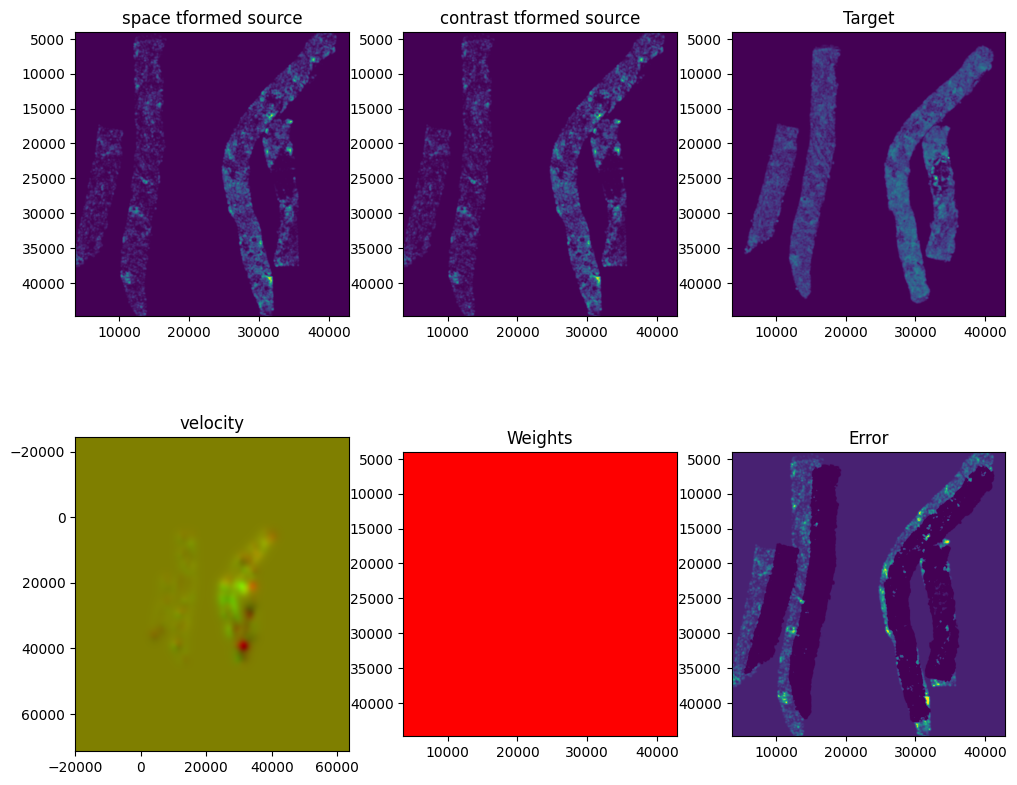

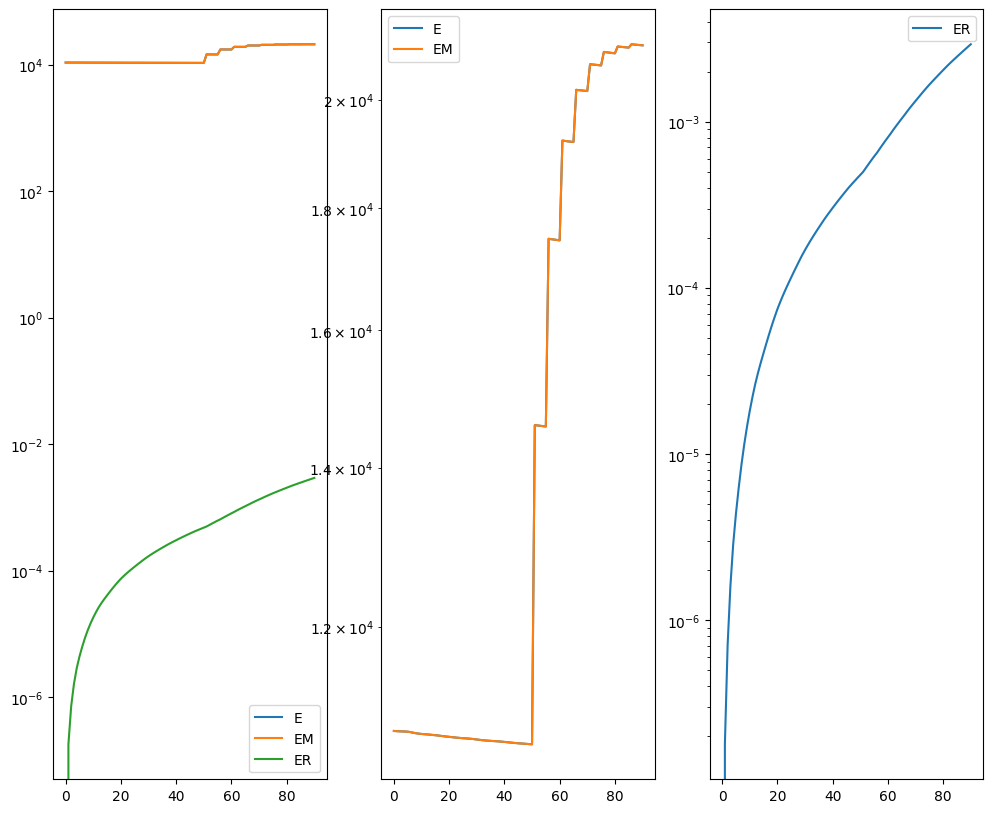

In [49]:
%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
from STalign.STalign import LDDMM
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 100,
            'device':device,
            'epV': 50
          }

out = LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [50]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

In [51]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

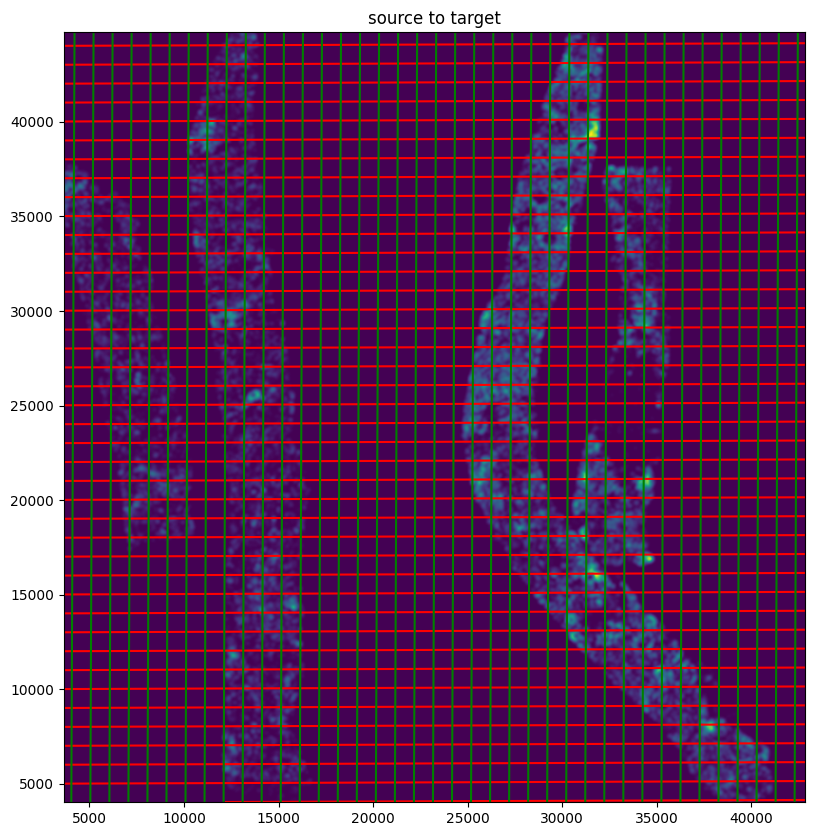

In [52]:
# apply transform
from STalign.STalign import build_transform,transform_image_source_to_target,transform_image_target_to_source
phii = build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

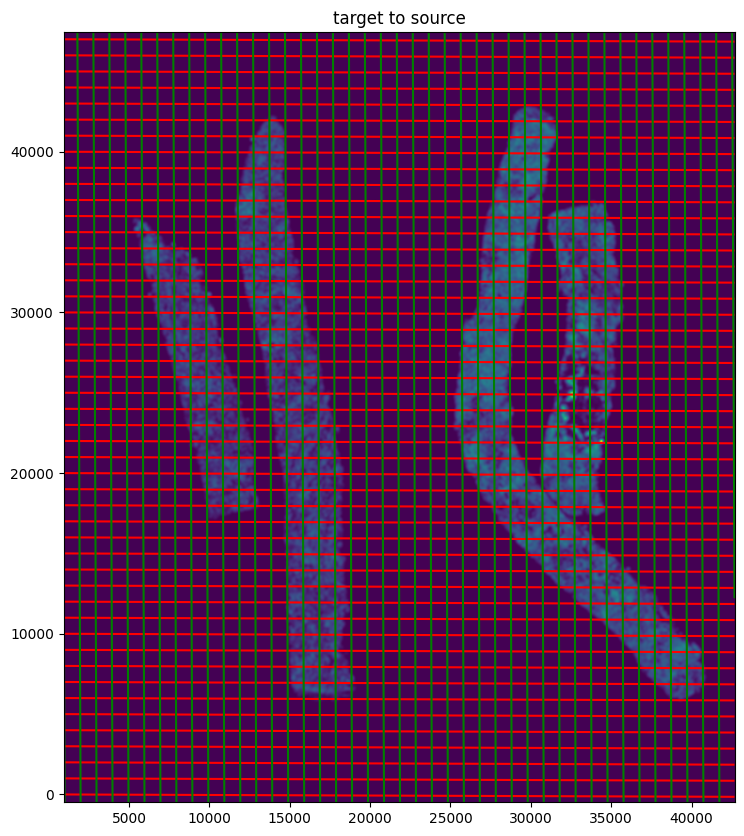

In [53]:
# transform is invertible
phi = build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = transform_image_target_to_source(xv,v,A,[YJ,XJ],J,[YI,XI])

#switch tensor from cuda to cpu for plotting with numpy
if phi.is_cuda:
    phi = phi.cpu()
if phiiJ.is_cuda:
    phiiJ = phiiJ.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.invert_yaxis()

In [54]:
from STalign.STalign import transform_points_source_to_target
# apply transform to original points
tpointsI= transform_points_source_to_target(xv,v,A, np.stack([yI_L_T, xI_L_T], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

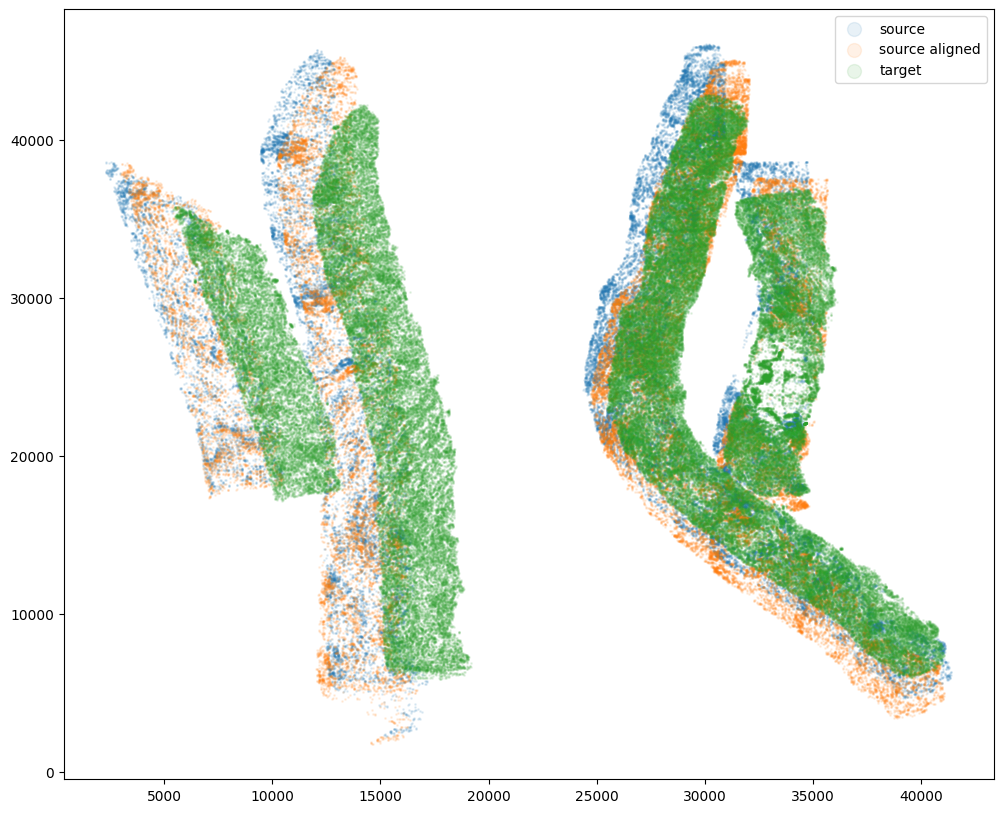

In [55]:
# plot results
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

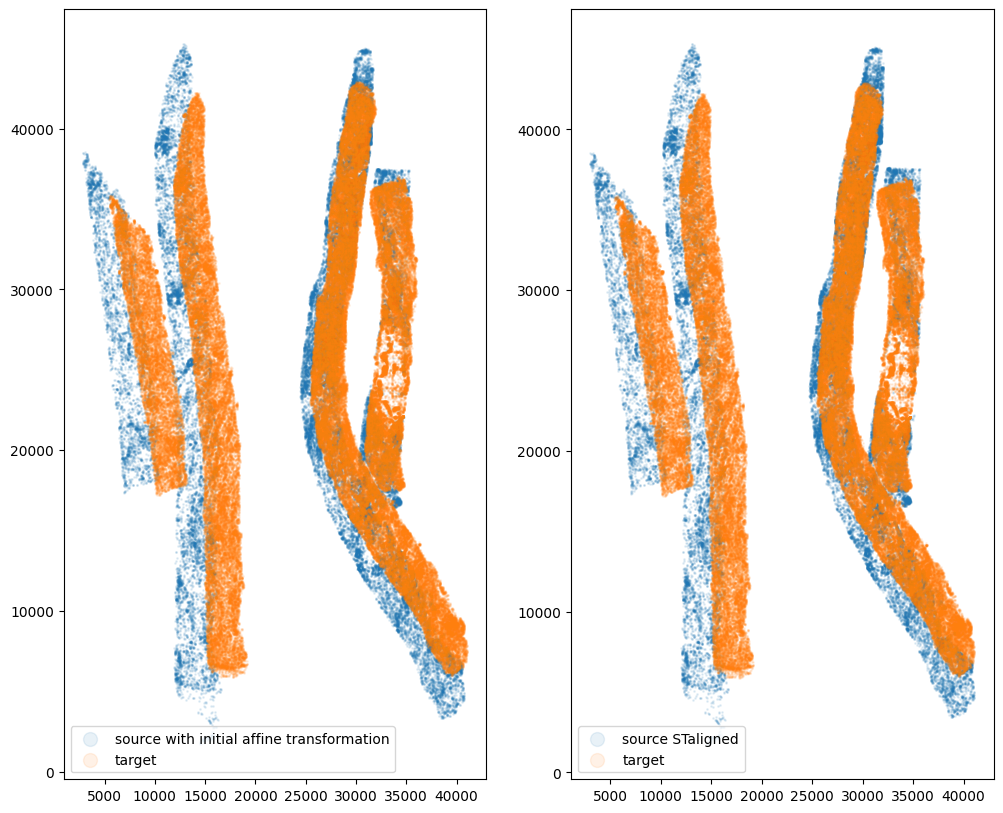

In [56]:
fig,ax = plt.subplots(1,2)
ax[0].scatter(xI_L_T,yI_L_T,s=1,alpha=0.1, label='source with initial affine transformation')
ax[0].scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax[1].scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source STaligned')
ax[1].scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax[0].legend(markerscale = 10, loc = 'lower left')
ax[1].legend(markerscale = 10, loc = 'lower left')

In [34]:
df3 = pd.DataFrame(

    {

        "aligned_x": xI_LDDMM,

        "aligned_y": yI_LDDMM,

    },


)

results = pd.concat([df1, df3], axis=1)
results.head()

x            y                  type      prob     aligned_x   
0  15441.365621  2556.252481  overall_inflammatory  1.000000  14987.337524  \
1  15295.593489  2250.416832  overall_inflammatory  1.000000  14825.543440   
2  15259.388646  2253.275109  overall_inflammatory  1.000000  14789.439782   
3  15199.364827  2336.165145  overall_inflammatory  0.999512  14733.625149   
4  15458.515284  2564.827312  overall_inflammatory  0.995117  15004.953272   

     aligned_y  
0  2744.617516  
1  2436.875503  
2  2439.221201  
3  2521.212076  
4  2753.426188